<a href="https://colab.research.google.com/github/AndreHucke/gen_ai/blob/main/VAE/waveform_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

Start by mounting the google drive directory so I don't have to upload the waveform file everything new runtime

cd into the right directory

print the path to the screen

---

In [12]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/PhD/Generative_AI_for_Engineers/
! pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PhD/Generative_AI_for_Engineers
/content/drive/MyDrive/PhD/Generative_AI_for_Engineers


---

Load the dataset and inspect its dimension

I chose pandas to read the csv since the data is tabular

I then print the df shape to get the amount of samples and the amount of features (2000 samples and 130 columns that includes labels and label names on the last two positions). I do a sanity check on my df, looking for any NA. I also look at the head of my df.

---

In [13]:
import pandas as pd

df = pd.read_csv('waveforms_two_class.csv')
print(f'Samples by features: {df.shape}')
print(f'Column names: {df.columns}')
print(f'NA check: {df.isna().sum().sum()}')
print(f'\nHead')
df.head()

Samples by features: (2000, 130)
Column names: Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'label',
       'label_name'],
      dtype='object', length=130)
NA check: 0

Head


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x120,x121,x122,x123,x124,x125,x126,x127,label,label_name
0,-0.947141,-0.838508,-0.897306,-0.891606,-0.882936,-0.873445,-0.956327,-0.889972,-0.888553,-0.932892,...,-0.941790,-0.885358,-0.840000,-0.869320,-0.986899,-0.855718,-0.925747,-0.887413,1,square
1,0.786143,0.944359,0.909509,0.828856,0.768542,0.692954,0.534794,0.414327,0.190835,-0.153061,...,-0.754151,-0.762131,-0.936944,-0.922856,-0.808356,-0.725042,-0.625543,-0.509568,0,sine
2,-0.911261,0.920661,0.791735,0.892718,0.911063,0.878976,0.900652,0.877653,0.870198,0.870511,...,0.878529,0.870021,0.898435,-0.869937,-1.000000,-0.774808,-0.915988,-0.849216,1,square
3,-0.783615,-0.900473,-0.925583,-0.989462,-0.745357,-0.693783,-0.444357,-0.271567,0.040077,0.280479,...,-0.113384,0.166106,0.416596,0.653322,0.719588,0.920724,1.000000,0.989300,0,sine
4,0.851972,0.885557,0.913848,0.862640,0.888450,-0.884866,-0.975754,-0.863823,-0.944364,-0.844752,...,-0.910218,-0.956567,-1.000000,-0.894092,-0.883763,-0.930647,0.899971,0.941150,1,square


---

Let's play around with some plots using seaborn, since I am most familiar with matplotlib and I want to learn something new (turns out it is just built on top of matplotlib, so I still need to use matplotlib. Seaborn is still coll for fast statistical plots like heatmaps).

I decided to randomly select a waveform from the dataset, drop the label and label_name features to be able to plot a line and then plot the type of waveform expected (label_name feature) on the title.

---

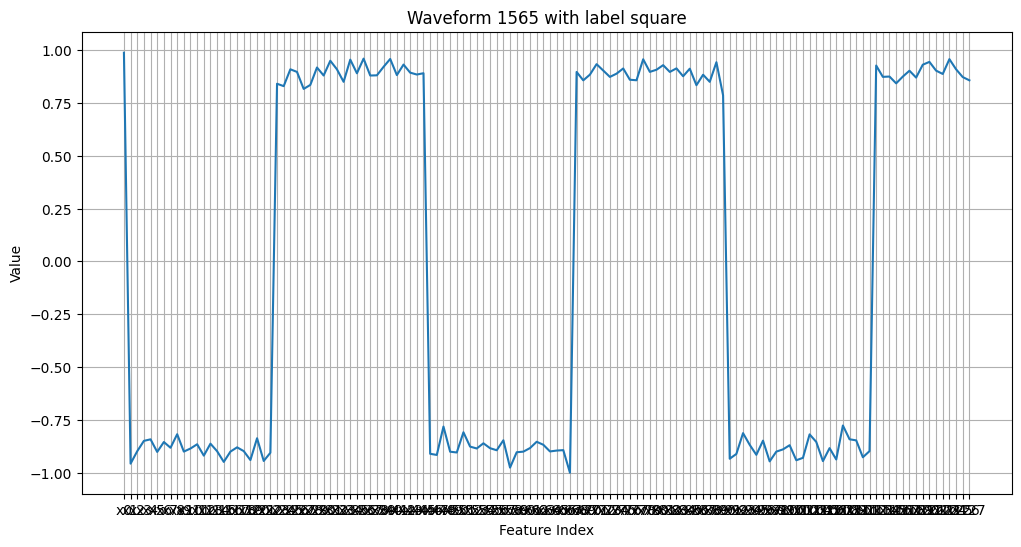

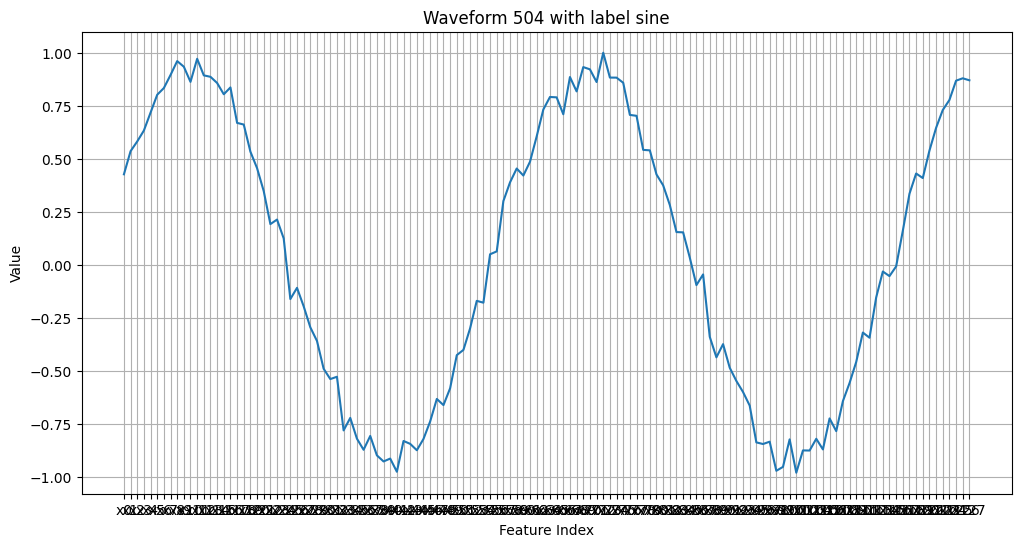

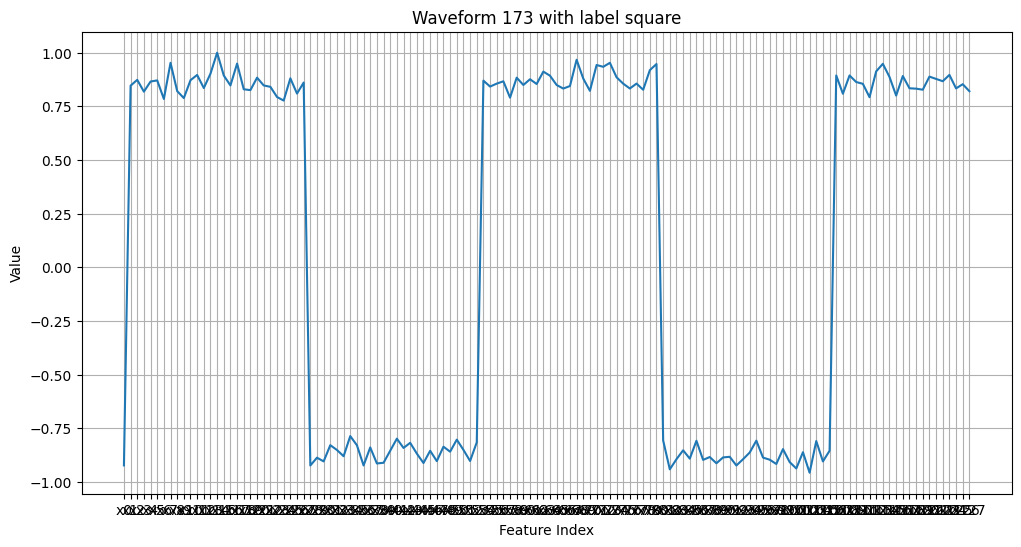

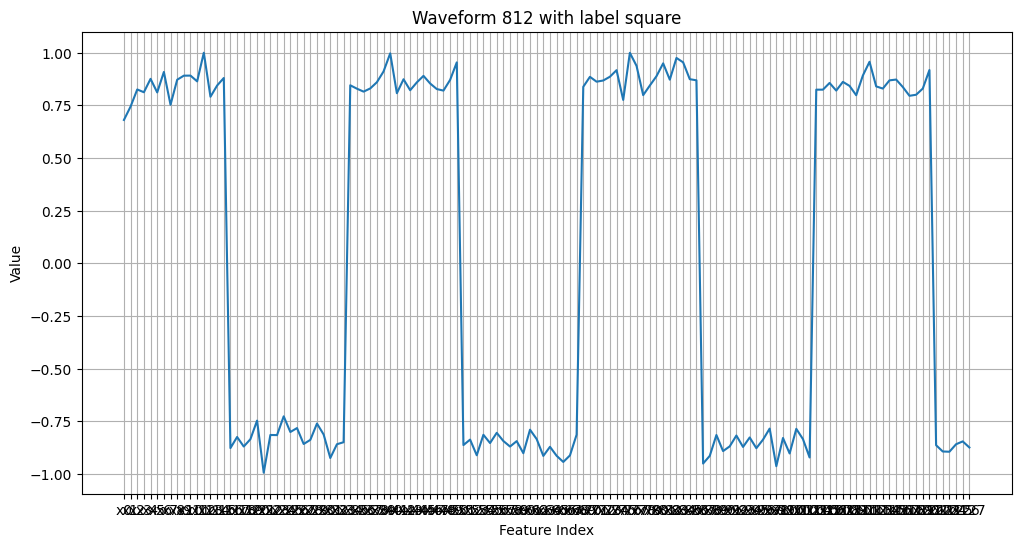

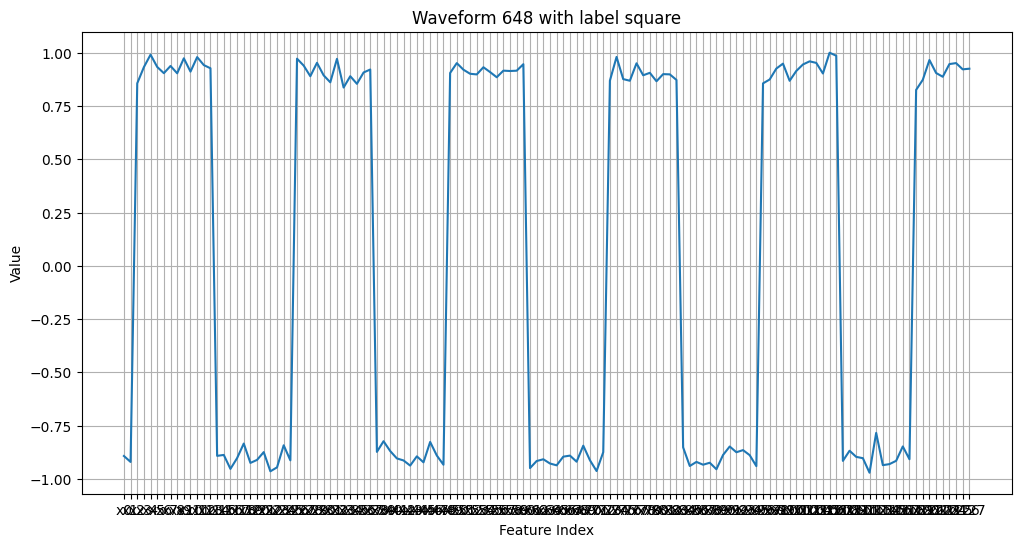

In [14]:
from numpy.random import randint
import seaborn
import matplotlib.pyplot as plt

for i in range(5):
  n = randint(0, len(df))

  row_numeric = df.iloc[n].drop(['label', 'label_name'])

  label_str = df.iloc[n]['label_name']

  plt.figure(figsize=(12, 6))
  seaborn.lineplot(x=row_numeric.index, y=row_numeric.values)
  plt.title(f'Waveform {n} with label {label_str}')
  plt.xlabel('Feature Index')
  plt.ylabel('Value')
  plt.grid(True)
  plt.show()

---

Load the torch libraries for the model creation

Create the train, val, test split with random splitting and class balance (I don't want to train only on sine waves, for instance)

Create the batch for each training step

---

In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare Features and Labels
# We need 'y' (labels) specifically for the stratify parameter,
# even though the VAE only trains on 'X'.
X = df.drop(['label', 'label_name'], axis=1).values
y = df['label'].values

# First Split: Separate Train (80%) from Temp (20%)
# stratify=y ensures class balance is maintained in both sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second Split: Separate Temp into Validation (10%) and Test (10%)
# We split the 20% chunk in half (0.5) to get two equal 10% chunks
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Initialize Scaler to fit between -1 and 1 (matching Tanh)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit on Train ONLY to prevent data leakage, then transform all
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Create TensorDatasets
# We strictly convert only the features (X) to tensors for the VAE
train_dataset = TensorDataset(torch.FloatTensor(X_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test))

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verification
print(f"Total samples: {len(df)}")
print(f"Train samples: {len(train_dataset)} ({len(train_dataset)/len(df):.0%})")
print(f"Val samples:   {len(val_dataset)} ({len(val_dataset)/len(df):.0%})")
print(f"Test samples:  {len(test_dataset)} ({len(test_dataset)/len(df):.0%})")

Total samples: 2000
Train samples: 1600 (80%)
Val samples:   200 (10%)
Test samples:  200 (10%)


---

Creating the VAE with torch

Since it is a VAE, we have an encoder block and a decoder block. The encoder compresses the data to a latent space and the decoder tries to reconstruct the data based only on that latent space.

The reparameterize block is

For my first pass, I decided to use a ReLU activation function, which in heinsight is not the best decision. In your dataset, we standardize the inputs from [-1 to 1] and a ReLU activation function would zero out those negative values, effectively losing the nuanced "shape" of your dataset.

So, the forward block uses a Leaky ReLU activation function. This choice was because Leaky ReLU is based on the reliable ReLU, but does not zero out negative values.

---

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=64, latent_dim=8):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # Mean (mu)
        self.fc22 = nn.Linear(hidden_dim, latent_dim) # Log variance (logvar)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        h1 = F.leaky_relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        h3 = F.leaky_relu(self.fc3(z))
        recon_x = torch.tanh(self.fc4(h3)) # Using Tanh since data is normalized in [-1, 1]

        return recon_x, mu, logvar

---

I decided to run a quick test to find the best hyper parameters, because I was curious to see what kind of behaviour would different hyper parameters show on small quick tests.

For question 9, I have a section commented out to force the hyper parameters to specific values.

First I define the loss function based on

Then I start my trial runs, with a small epoch for quickness and a short window for early stopping. I iterate through the epoch and batches and then validate.

The random search start on the next for loop, and selects the appropriate parameters. This selection is based on if they are int or float (for the learning rate). I have add a else statement for question 9, where I skip the parameter randomization and just use the parameter given by me.

I do a few print statemnet to se the training happening and save the best model hyper parameters at the end.

---

In [23]:
import random
import math
import torch.optim as optim
import torch

# Define the Search Space
# We define lists of potential values for each hyperparameter
param_grid = {
    'latent_dim': (4, 64, 'int'),
    'hidden_dim': (16, 256, 'int'),
    'lr': (1e-4, 1e-1, 'log-uniform')
}

# UNCOMMENT FOR QUESTION 9:
# param_grid = {
#     'latent_dim': [8, 16, 32, 64],
#     'hidden_dim': [32, 64, 128, 256],
#     'lr': [1e-2, 1e-3, 5e-4]
# }

# Define Loss Function
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Wrapper Function for Training
def train_trial(config, trial_id):
    """
    Trains a model with specific hyperparameters for a limited number of epochs
    to determine viability. Returns the best validation loss achieved.
    """
    # Instantiate model with dynamic config
    model = VAE(
        input_dim=128,
        hidden_dim=config['hidden_dim'],
        latent_dim=config['latent_dim']
    )

    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    # Search settings (faster than full training)
    epochs = 30          # Fewer epochs for search to save time
    patience = 5         # Aggressive early stopping
    best_loss = float('inf')
    counter = 0

    print(f"\n--- Trial {trial_id} | Config: {config} ---")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            data = batch[0]
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            loss = loss_function(recon, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                data = batch[0]
                recon, mu, logvar = model(data)
                loss = loss_function(recon, data, mu, logvar)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader.dataset)

        # Check for improvement
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"   Early stopping at epoch {epoch+1}")
            break

    print(f"   Best Val Loss: {best_loss:.4f}")
    return best_loss

# Execution Loop
num_trials = 50
results = []

print(f"Starting Random Search for {num_trials} trials...")

for i in range(num_trials):
    config = {}

    for key, val in param_grid.items():
        if isinstance(val, tuple):
            low, high, dist_type = val

            if dist_type == 'int':
                # Pick a random integer between low and high
                config[key] = random.randint(low, high)

            elif dist_type == 'log-uniform':
                # Pick a random float on a logarithmic scale
                log_low = math.log10(low)
                log_high = math.log10(high)
                config[key] = 10 ** random.uniform(log_low, log_high)

        # For question 9:
        else:
          # Fallback to use a simple list for question 9
          config[key] = random.choice(val)

    # Force integer types for dimensions (crucial for PyTorch)
    config['hidden_dim'] = int(config['hidden_dim'])
    config['latent_dim'] = int(config['latent_dim'])

    # Run trial
    # We use a try/except block to catch bad combos (like negative dimensions) just in case
    try:
        final_loss = train_trial(config, i+1)
        results.append((config, final_loss))
    except Exception as e:
        print(f"Trial {i+1} failed with error: {e}")
        results.append((config, float('inf')))

# Analyze Results
results.sort(key=lambda x: x[1])

print("\n" + "="*40)
print("TOP 3 CONFIGURATIONS")
print("="*40)
for rank, (cfg, loss) in enumerate(results[:3]):
    print(f"{rank+1}. Loss: {loss:.4f} | {cfg}")

if results:
    best_config = results[0][0]
    print(f"\nWinner: {best_config}")

    # Re-instantiate the best model for the final full training run
    model = VAE(
        input_dim=128,
        hidden_dim=best_config['hidden_dim'],
        latent_dim=best_config['latent_dim']
    )
    optimizer = optim.Adam(model.parameters(), lr=best_config['lr'])
    print("\nModel reset with winning hyperparameters. Ready for full training.")

Starting Random Search for 50 trials...

--- Trial 1 | Config: {'latent_dim': 20, 'hidden_dim': 184, 'lr': 0.0009657015931234669} ---
   Early stopping at epoch 29
   Best Val Loss: 25.5680

--- Trial 2 | Config: {'latent_dim': 17, 'hidden_dim': 161, 'lr': 0.0010341424938172332} ---
   Best Val Loss: 24.8119

--- Trial 3 | Config: {'latent_dim': 10, 'hidden_dim': 209, 'lr': 0.004280869430951923} ---
   Best Val Loss: 21.8428

--- Trial 4 | Config: {'latent_dim': 19, 'hidden_dim': 225, 'lr': 0.001820751578125564} ---
   Best Val Loss: 24.3424

--- Trial 5 | Config: {'latent_dim': 5, 'hidden_dim': 108, 'lr': 0.00029855644633140153} ---
   Best Val Loss: 36.8112

--- Trial 6 | Config: {'latent_dim': 55, 'hidden_dim': 224, 'lr': 0.00421791209969589} ---
   Best Val Loss: 23.0211

--- Trial 7 | Config: {'latent_dim': 32, 'hidden_dim': 159, 'lr': 0.03176620851640802} ---
   Early stopping at epoch 18
   Best Val Loss: 36.5613

--- Trial 8 | Config: {'latent_dim': 49, 'hidden_dim': 144, 'lr':

---

Running the full model with the winner. Very similar to the trial runs, but with more epochs and patiente for a longer training session.

I also do a few plots to see loss and some random examples while the training is happening.

---

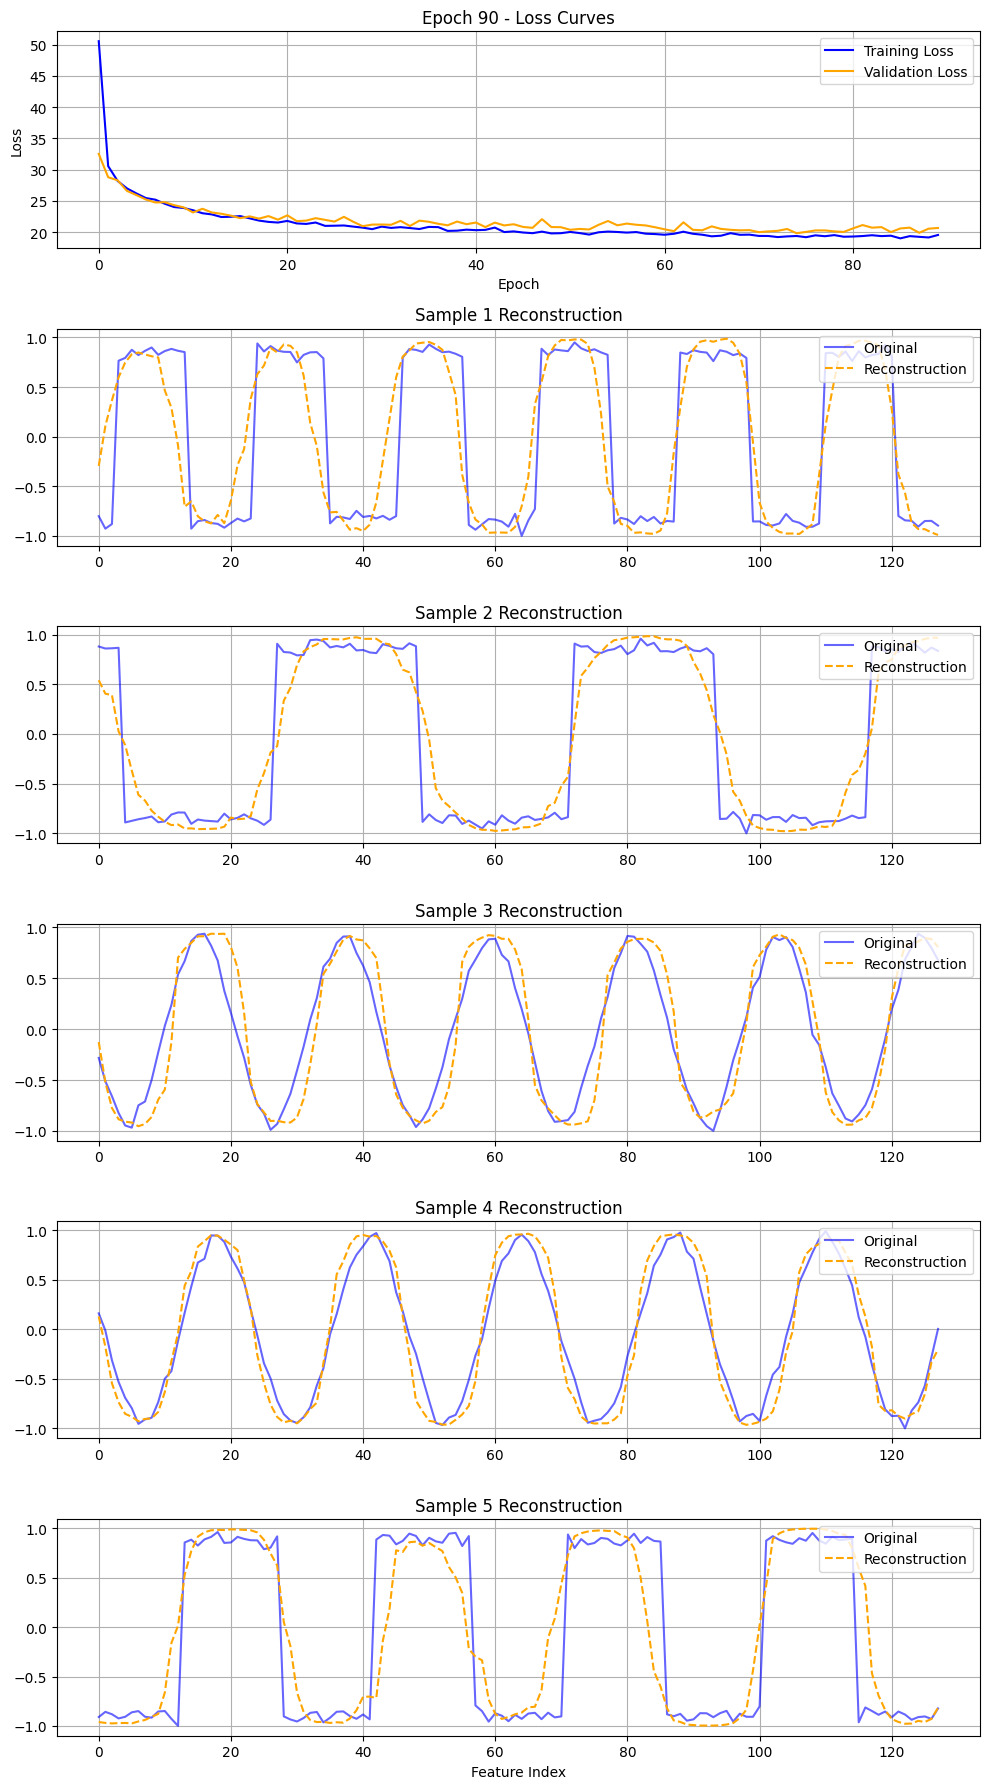

Epoch 90 | Train Loss: 19.5475 | Val Loss: 20.6677

Early stopping triggered at epoch 90.
Best model loaded.


In [18]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.optim as optim

# Setup Fixed Validation Samples for Visualization
# We pick these ONCE so we can watch the SAME waveforms improve over time.
data_iter = iter(val_loader)
fixed_batch = next(data_iter)[0]
fixed_indices = torch.randperm(fixed_batch.size(0))[:5]
fixed_originals = fixed_batch[fixed_indices]

# Setup Model & Optimizer
model = VAE(
    input_dim=128,
    hidden_dim=best_config['hidden_dim'], # Use the winner
    latent_dim=best_config['latent_dim']  # Use the winner
)
optimizer = optim.Adam(model.parameters(), lr=best_config['lr']) # Use the winner

# Early Stopping parameters
max_epochs = 200
patience = 15
best_val_loss = float('inf')
patience_counter = 0
plot_interval = 10

train_losses = []
val_losses = []

print("Starting training...")

# Training Loop
for epoch in range(max_epochs):
    # Train Step
    model.train()
    train_loss = 0
    for batch in train_loader:
        data = batch[0]
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation Step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0]
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # Real-Time Visualization (Conditional)
    # Plot on first epoch, every 10th epoch, or if early stopping triggers
    if (epoch + 1) % plot_interval == 0 or epoch == 0:
        clear_output(wait=True)

        # Run inference on our FIXED samples
        with torch.no_grad():
            fixed_recons, _, _ = model(fixed_originals)

        # Create figure
        fig, axes = plt.subplots(6, 1, figsize=(10, 18))

        # Plot 1: Loss Curves
        axes[0].plot(train_losses, label='Training Loss', color='blue')
        axes[0].plot(val_losses, label='Validation Loss', color='orange')
        axes[0].set_title(f'Epoch {epoch+1} - Loss Curves')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)

        # Plot 2-6: Waveform Reconstructions
        for i in range(5):
            ax = axes[i+1]
            ax.plot(fixed_originals[i].numpy(), label='Original', color='blue', alpha=0.6)
            ax.plot(fixed_recons[i].numpy(), label='Reconstruction', color='orange', linestyle='--')
            ax.set_title(f'Sample {i+1} Reconstruction')
            if i == 4:
                ax.set_xlabel('Feature Index')
            ax.legend(loc='upper right')
            ax.grid(True)

        plt.tight_layout()
        plt.show()

    # Print text status every epoch so you know it's still running
    print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

    # D. Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_vae_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered at epoch {epoch+1}.')
            break

# Load best model at the end
model.load_state_dict(torch.load('best_vae_model.pth'))
print("Best model loaded.")

---

Here we are trying to see if the model has clusters using UMAP. I chose UMAP because

---

Extracting latent representations from Test Set...
Applying UMAP to latent space (Dim: 11)...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


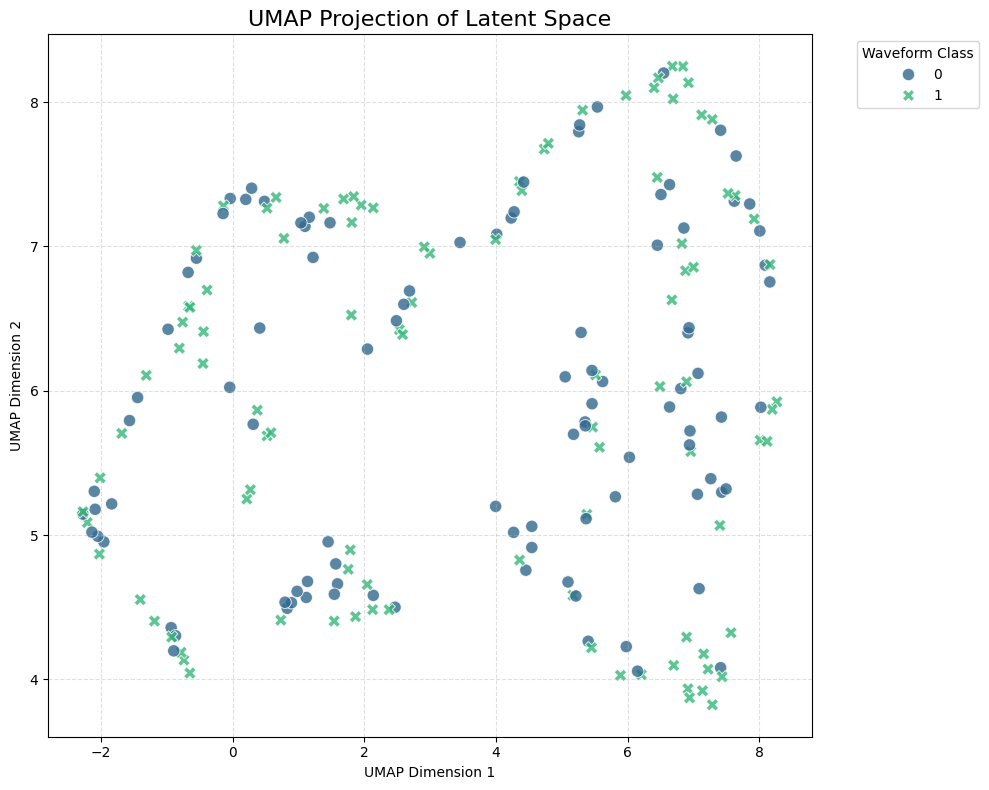

In [19]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Extract Latent Representations (Mu)
model.eval()
print("Extracting latent representations from Test Set...")

# Get the full test tensor directly
# We use the tensor we created earlier in test_dataset
full_test_tensor = test_dataset.tensors[0]

with torch.no_grad():
    # Pass through encoder to get mu (latent mean)
    _, mu, _ = model(full_test_tensor)
    latent_space = mu.numpy()

# Apply UMAP
print(f"Applying UMAP to latent space (Dim: {latent_space.shape[1]})...")

# n_neighbors: Balances local vs global structure (default 15)
# min_dist: Controls how tightly points are packed together (default 0.1)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
latent_2d = reducer.fit_transform(latent_space)

x_axis, y_axis = latent_2d[:, 0], latent_2d[:, 1]

# 4. Visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=x_axis,
    y=y_axis,
    hue=y_test,
    palette='viridis',
    style=y_test,
    s=80,
    alpha=0.8
)

plt.title('UMAP Projection of Latent Space', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Waveform Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

---

Let's see some generated curves.

First, I

---

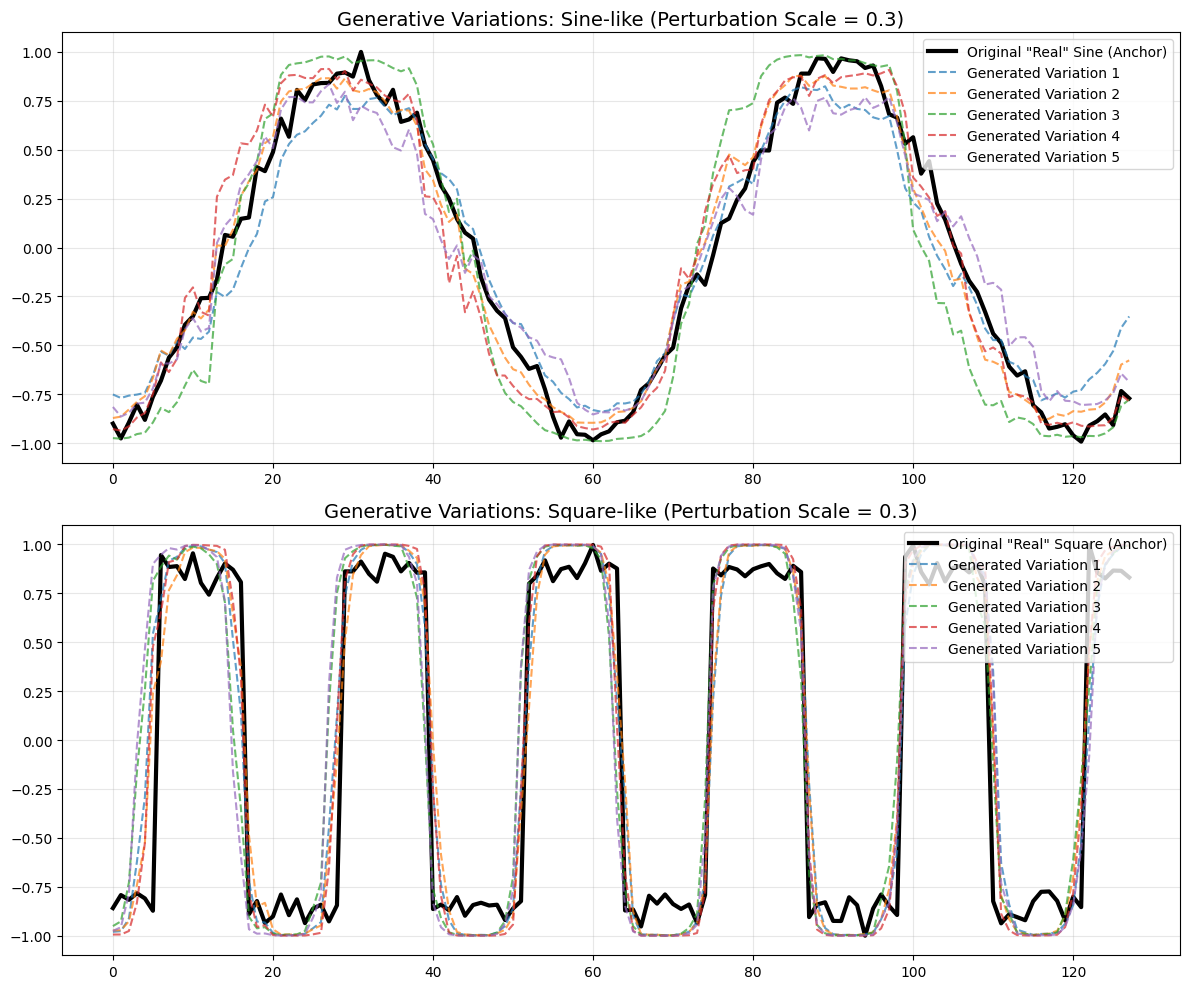

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Settings ---
# perturbation_scale: Controls how distinct the new waves are.
# 0.1 = Very similar (almost identical)
# 0.5 = Distinct variations (same shape, different character)
# 1.0 = Highly generative (might start looking distorted)
perturbation_scale = 0.3
num_variations = 5

# Find Reference Samples ("Anchors") in the Test Set
# Based on your previous plots: Class 0 = Sine-like, Class 1 = Square-like
idx_sine = np.where(y_test == 0)[0][0]    # First Class 0 sample
idx_square = np.where(y_test == 1)[0][0]  # First Class 1 sample

# Get the actual tensors for these anchors
anchor_sine = test_dataset[idx_sine][0].unsqueeze(0)   # Add batch dim [1, 128]
anchor_square = test_dataset[idx_square][0].unsqueeze(0)

# Get their "Address" in Latent Space
model.eval()
with torch.no_grad():
    _, mu_sine, _ = model(anchor_sine)
    _, mu_square, _ = model(anchor_square)

# Generate New Variations (Latent Perturbation)
generated_sines = []
generated_squares = []

with torch.no_grad():
    for _ in range(num_variations):
        # Create random noise vector of the same size
        noise = torch.randn_like(mu_sine) * perturbation_scale

        # Add noise to the original centroid (The "Perturbation")
        z_sine_new = mu_sine + noise
        z_square_new = mu_square + noise

        # Decode these new, never-before-seen latent points
        # (Manually running the decoder half of the model)
        recon_sine = torch.tanh(model.fc4(torch.nn.functional.relu(model.fc3(z_sine_new))))
        recon_square = torch.tanh(model.fc4(torch.nn.functional.relu(model.fc3(z_square_new))))

        generated_sines.append(recon_sine.squeeze().numpy())
        generated_squares.append(recon_square.squeeze().numpy())

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot Sine-like Generative Results
ax = axes[0]
ax.plot(anchor_sine.squeeze().numpy(), color='black', linewidth=3, label='Original "Real" Sine (Anchor)')
for i, wave in enumerate(generated_sines):
    ax.plot(wave, alpha=0.7, linestyle='--', label=f'Generated Variation {i+1}')
ax.set_title(f'Generative Variations: Sine-like (Perturbation Scale = {perturbation_scale})', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(-1.1, 1.1)

# Plot Square-like Generative Results
ax = axes[1]
ax.plot(anchor_square.squeeze().numpy(), color='black', linewidth=3, label='Original "Real" Square (Anchor)')
for i, wave in enumerate(generated_squares):
    ax.plot(wave, alpha=0.7, linestyle='--', label=f'Generated Variation {i+1}')
ax.set_title(f'Generative Variations: Square-like (Perturbation Scale = {perturbation_scale})', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()

---

As for the transition between one class to the other, this was the first output by Gemini. It is showing how

---

Generating interpolated waves...


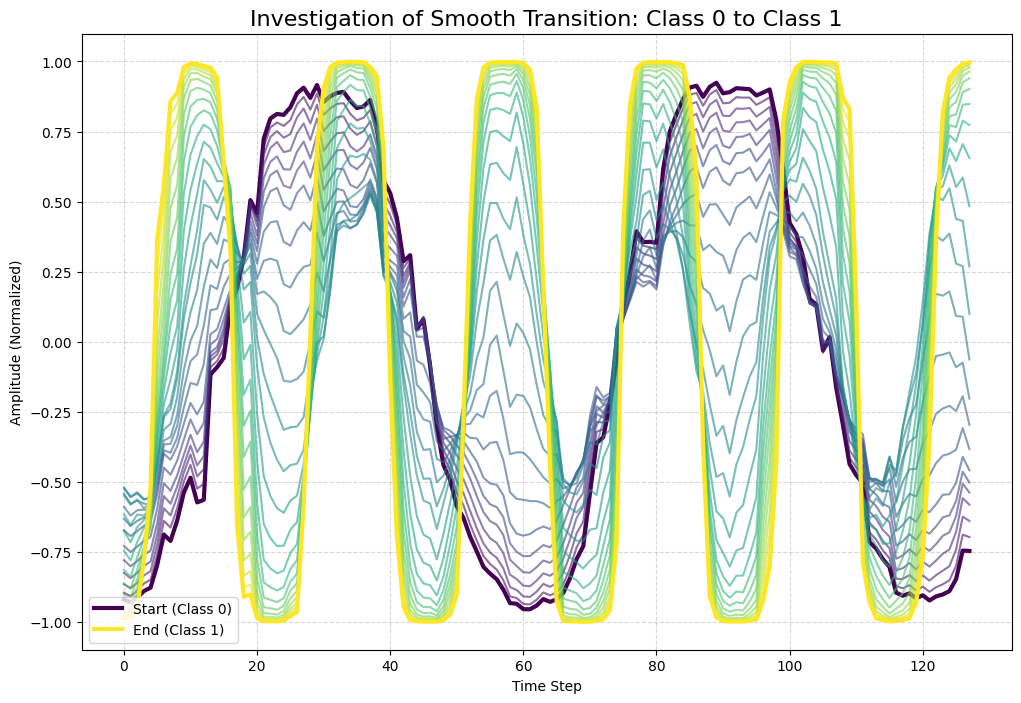

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Select Start (Class 0) and End (Class 1) samples
# We search the test set for the first instance of each class
idx0 = np.where(y_test == 0)[0][0]
idx1 = np.where(y_test == 1)[0][0]

# Get their tensors and add batch dimension [1, 128]
wave0 = test_dataset[idx0][0].unsqueeze(0)
wave1 = test_dataset[idx1][0].unsqueeze(0)

# Encode to get Latent Vectors (Mu)
model.eval()
with torch.no_grad():
    _, mu0, _ = model(wave0)
    _, mu1, _ = model(wave1)

# Interpolate
steps = 25
# Create 10 steps from 0 to 1 (0% to 100% mixture)
alphas = torch.linspace(0, 1, steps)
interpolated_waveforms = []

print("Generating interpolated waves...")
with torch.no_grad():
    for alpha in alphas:
        # Linear Interpolation formula: z = (1-a)*start + a*end
        z_interp = (1 - alpha) * mu0 + alpha * mu1

        # Decode the interpolated latent vector
        # Note: We manually pass it through decoder layers (fc3 -> fc4)
        h3 = torch.nn.functional.relu(model.fc3(z_interp))
        recon_interp = torch.tanh(model.fc4(h3))
        interpolated_waveforms.append(recon_interp.squeeze().numpy())

# Plot
plt.figure(figsize=(12, 8))

# Color map from Purple (Start) to Yellow (End)
colors = plt.cm.viridis(np.linspace(0, 1, steps))

for i, wave in enumerate(interpolated_waveforms):
    # Highlight start and end lines
    if i == 0:
        label = "Start (Class 0)"
        lw = 3
        alpha_val = 1.0
    elif i == steps - 1:
        label = "End (Class 1)"
        lw = 3
        alpha_val = 1.0
    else:
        label = None
        lw = 1.5
        alpha_val = 0.6 # Make intermediates slightly transparent

    plt.plot(wave, color=colors[i], linewidth=lw, alpha=alpha_val, label=label)

plt.title('Investigation of Smooth Transition: Class 0 to Class 1', fontsize=16)
plt.xlabel('Time Step')
plt.ylabel('Amplitude (Normalized)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---

Then, with your guidance, I went the traditional way of seeing how one class "moves" to the other in the UMAP latent sapce.

---

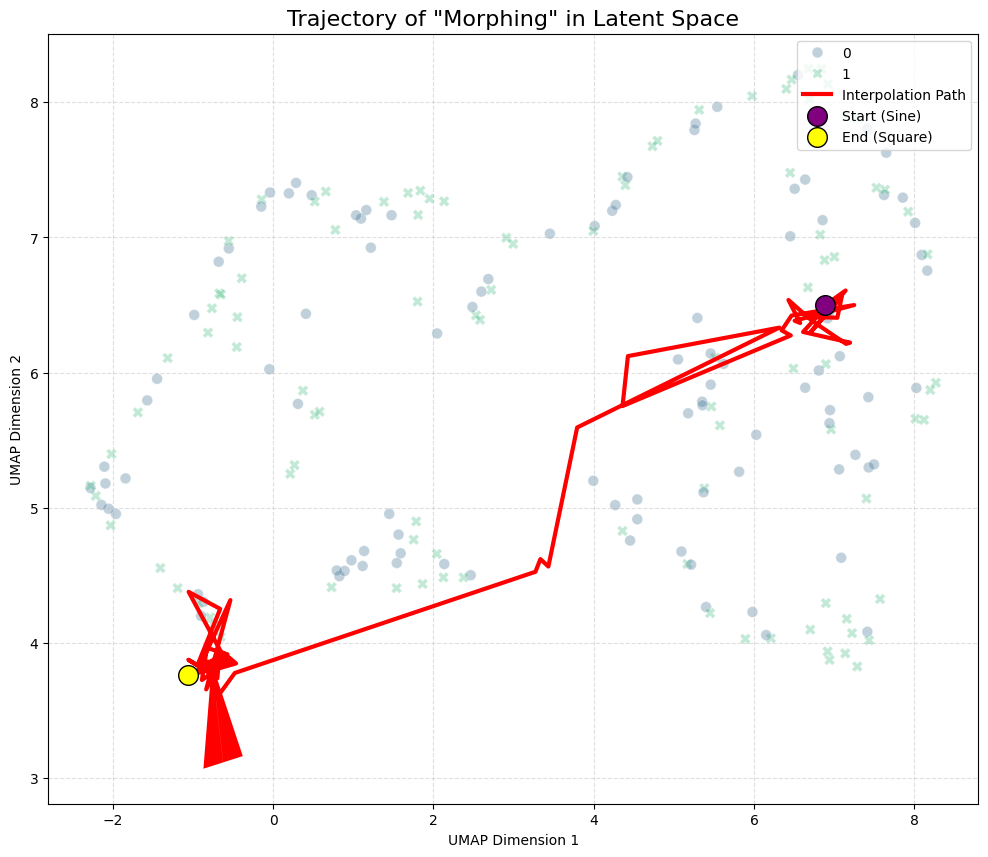

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the High-Dimensional Path (More detailed this time)
steps = 50  # More steps for a smoother line in the plot
alphas = torch.linspace(0, 1, steps)
path_high_dim = []

model.eval()
with torch.no_grad():
    for alpha in alphas:
        # Linear mix of the two latent vectors
        z_interp = (1 - alpha) * mu0 + alpha * mu1
        path_high_dim.append(z_interp.numpy())

# Convert to numpy array [steps, latent_dim]
path_high_dim = np.vstack(path_high_dim)

# Project the Path to 2D
# CRITICAL: We use the SAME reducer we already trained.
# This ensures the path lands in the correct spot on the existing map.
path_2d = reducer.transform(path_high_dim)

# Plot
plt.figure(figsize=(12, 10))

# Background: The original Test Set clusters
sns.scatterplot(
    x=latent_2d[:, 0],
    y=latent_2d[:, 1],
    hue=y_test,
    palette='viridis',
    style=y_test,
    s=60,
    alpha=0.3  # Make background fainter so the path pops
)

# Foreground: The Interpolation Path
# Plot the trajectory line
plt.plot(path_2d[:, 0], path_2d[:, 1],
         color='red', linewidth=3, linestyle='-', label='Interpolation Path')

# Plot the Start and End points
plt.scatter(path_2d[0, 0], path_2d[0, 1],
            c='purple', s=200, edgecolors='black', label='Start (Sine)', zorder=10)
plt.scatter(path_2d[-1, 0], path_2d[-1, 1],
            c='yellow', s=200, edgecolors='black', label='End (Square)', zorder=10)

# Arrows to show direction (optional but helpful)
# Add an arrow at the midpoint
mid_idx = steps // 2
plt.arrow(path_2d[mid_idx, 0], path_2d[mid_idx, 1],
          path_2d[mid_idx+1, 0] - path_2d[mid_idx, 0],
          path_2d[mid_idx+1, 1] - path_2d[mid_idx, 1],
          shape='full', lw=0, length_includes_head=True, head_width=0.5, color='red')

plt.title('Trajectory of "Morphing" in Latent Space', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

---

After playing around with a bunch of hyper parameters, I saw that the latent space size affected the


Below, I printed the plots comparing each user selected latent space plus the one where I did a random search.

---

In [ ]:
# Print each hyper parameter and their reconstructions